Program to identify suspicious values in Prim master file by comparing it with RTWS daily PRIM files

In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
plt.style.use('fivethirtyeight')

from datetime import datetime, time, timedelta
from numpy import array, polyfit, poly1d
from pandas import DataFrame, to_datetime
from pandas.plotting import register_matplotlib_converters
from tkinter import *
from tkinter import filedialog

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import os, sys
import pylab
import scipy as sp
import scipy.stats

%matplotlib inline

In [2]:
def get_master_file():

# Select input file
    root = Tk()
    root.filename =  filedialog.askopenfilename(initialdir = "C:\QGHL\Wave_data\Masters", title = "Select Master file",\
                        filetypes = (("Prim files","*.prim"),("Seco files","*.seco"),("Dseco files","*.dseco.corrected"),("all files","*.*")))
    root.destroy()

    return(root.filename)

In [3]:
def get_RTWS_file():

# Select input file
    root = Tk()
    root.filename =  filedialog.askopenfilename(initialdir = 'C:\QGHL\Wave_data', title = 'Select RTWS PRIM file',\
                        filetypes = (('all files','*.*'),('Prim files','*.prim'),('Seco files','*.seco')))
    root.destroy()
    
    print(root.filename)

    return(root.filename)

In [4]:
def Date_range(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

In [5]:
def remove_zeros(recs,Input_File):

# Locate, and remove errant zero's from data
    zero_data = recs.loc[recs.date_val.apply(lambda x: x[0])==0].index
    if len(zero_data) > 0:
        recs_zero = recs    # make a copy to locate where the zeros occur
        date_string =  [[recs.loc[zero_data[0]-1].date_val.tolist()][0][i] for i in range(0,10,2)]
        ' '.join(str(p) for p in [date_string])
        first_val = str(date_string[0])+'/'+str(date_string[1])+'/'+str(date_string[2])+' '+str(date_string[3]) \
            +':'+str(date_string[4])
        date_string =  [[recs.loc[zero_data[-1]+1].date_val.tolist()][0][i] for i in range(0,10,2)]
        ' '.join(str(p) for p in [date_string])
        last_val = str(date_string[0])+'/'+str(date_string[1])+'/'+str(date_string[2])+' '+str(date_string[3]) \
            +':'+str(date_string[4])
        print('Alert: ',len(zero_data),' Zero\'s found (and removed) between ',first_val,' and ',last_val)
    else:
        print('No zeros found in ',Input_File)

    recs = recs.loc[recs.date_val.apply(lambda x: x[0])!=0]

    return(recs)

In [6]:
def convert_dates(recs):
# Convert date/time column data into Dates and times
    Record_time = pd.DataFrame(recs.date_val.values.tolist(), \
            columns=['year','j1','month','j2','day','j3','hour','j4','minute','j5','second','j6'])

    Record_time['year'] = Record_time['year'].mask(Record_time['year'] < 1900, Record_time['year'] + 1900)

    # Insert Date column at start of DF
    recs.index = pd.to_datetime(Record_time[['year','month','day','hour','minute','second']],format='%Y:%m:%d:%H:%M:%S')

    return(recs)

In [7]:
def get_RTWS_data(recs):
    
    Start_File = get_RTWS_file()
    date_str = Start_File.split('/')[-1].split('.')[0]
    Start_time = datetime.strptime(date_str[3:], "%d%m%Y")

    # Get name of input PRIM file
    site = Start_File.split('/')[-1].split('}')[0].upper()

    ##End_File = get_file()
    ##date_str = End_File.split('/')[-1].split('.')[0]
    ##End_time = datetime.strptime(date_str[3:], "%d%m%Y")
    End_time = Start_time + timedelta(days=365)

    Path = os.path.dirname(Start_File)
    File_name = os.path.basename(Start_File)

    Front_part = Start_File.split('/')[0]
    Extension = Start_File.split('.')[-1]

    Days = (End_time-Start_time).days

    aa = []

    for dt in Date_range(Start_time, End_time):
        Input_File = Path+'/'+date_str[0:3]+dt.strftime("%d%m%Y")+'.'+Extension

        error_to_catch = getattr(__builtins__,'FileNotFoundError', IOError)

        try:
    # Read data from the HVA file
            print('Reading data from RTWS Prim file:',Input_File)
            # Open file
            f = open(Input_File)

            # Read data from the Binary file into a DF based on the structure in the DT
            data = np.fromfile(f, rectype)
            aa.append(DataFrame.from_records(np.array(data).tolist()))

        except error_to_catch:
            print('WARNING... ',Input_File,' NOT Found!')

    recs = pd.concat(aa)
    # Assign column names to DF
    recs.columns = ['Date_val','Buoy','Verstr','Hsig','Hm','Hmax','Tz','Thsig','Tc','Thmax','Eps','T02',
                    'Tp','Hrms','Epss','Noise','Nspike','Nroc','Errors','Spikemax','Rocmax',
                    'Samax','Sigma','Burlen','Deltat','Nwaves','Tzmax','E04','E60','Ierr','Start',
                    'Burint','H10','Th10','Elapse','Hm0','Dtz','Pdens','Rtemp','Wtemp','Status',
                    'Vacc','Xacc','Yacc','Orient','Inclin','Pktdir','Avedir','Pkdir','Pad']

    # Convert date/time column data into Dates and times
    Record_time = pd.DataFrame(recs.Date_val.values.tolist(), \
            columns=['year','month','day','hour','minute','second'])

    Record_time['year'] = Record_time['year'].mask(Record_time['year'] < 1900, Record_time['year'] + 1900)

    # Insert Date column at start of DF
    recs.index = pd.to_datetime(Record_time[['year','month','day','hour','minute','second']],format='%Y:%m:%d:%H:%M:%S')
    
    return(recs)


In [8]:
def get_PRIM_Master_data(recs_prim):
    ############################################################################################
    # Get name of input PRIM Master file
    Input_Prim_File = get_master_file()
    site = Input_Prim_File.split('/')[-1].split('}')[0].upper()

    # Open file
    f = open(Input_Prim_File)

    # Read data from the Binary file into a DF based on the structure in the DT
    data = np.fromfile(f, rectype_prim)
    recs_prim = DataFrame.from_records(np.array(data).tolist())

    # Assign column names to DF
    recs_prim.columns = ['Procid','Loc','date_val','Hsig','Thsig','Hrms','Hmax','Tc','Tz','H10','Th10',
                         'Thmax','Tzmax','Hm0','T02','Tp','EPS','Npts','Param2']

    # Locate, and remove errant zero's from data
    recs_prim = remove_zeros(recs_prim,Input_Prim_File)

    # Convert date/time column data into Dates and times
    recs_prim = convert_dates(recs_prim)

    # Remove unwanted columns from Prim DF
    recs_prim = recs_prim.drop(columns=[
        'Procid',
        'Loc',
        'date_val',
        'Param2'], axis=1)
 
    return(recs_prim,Input_Prim_File)


In [9]:
############################################
#    MAIN PROGRAM
############################################

# Create a DT based on the structure type of the PRIM Master File
# Details copied from PV~Wave file Master_structure_types_corrected.pro
pp1 = np.dtype([
    ('P1', 'B'),('P2', 'B'),('P3', 'B'),('P4', 'B'),('P5', 'B'),('P6', 'B'),('P7', 'B'),('P8', 'B'),
    ('P9', 'B'),('P10', 'B'),('P11', 'B'),('P12', 'B')])
pp2 = np.dtype([('p1', 'f'),('p2', 'f'),('p3', 'f'),('p4', 'f')])

rectype_prim = np.dtype([
    ('Procid',pp1),
    ('Loc','i'),
#    ('Year','i'),('Month','i'),('Day', 'i'),('Hour', 'i'),('Min', 'i'), ('Sec','i'), 
    ('date_val','i2',(12)),
    ('Hsig','f4'), ('Thsig','f4'), ('Hrms', 'f'), ('Hmax', 'f'),('Tc', 'f'),('Tz', 'f'), ('H10', 'f'), 
    ('Th10', 'f'), ('Thmax', 'f'), ('Tzmax', 'f'), ('Hm0', 'f4'),('T02', 'f'),('Tp', 'f'), ('EPS', 'f'), 
    ('Npts', 'i'),
    ('Param2',pp2)])

# Create a DT based on the structure type of the RTWS daily PRIM file
# Details copied from PV~Wave file Master_structure_types_corrected.pro
pp3 = np.dtype([
    ('P1', 'B'),('P2', 'B'),('P3', 'B'),('P4', 'B'),('P5', 'B'),('P6', 'B'),('P7', 'B'),('P8', 'B')])

rectype = np.dtype([
#    ('Year','i2'),('Month','i2'),('Day', 'i2'),('Hour', 'i2'),('Min', 'i2'), ('Sec','i2'), 
    ('Date_val','i2',(6)), 
    ('Buoy','i2'),
#    ('verstr',pp1),
    ('verstr','B',(8,)),
    ('Hsig','f4'),('Hm','f4'), ('Hmax', 'f4'),('Tz', 'f4'),('Thsig','f4'),('Tc', 'f4'), 
    ('Thmax', 'f4'),('Eps', 'f4'),('T02', 'f4'),
    ('Tp', 'f4'),('Hrms', 'f4'),('Epss', 'f4'),
    ('Noise', 'i2'),('Nspike', 'i2'),('Nroc', 'i2'),
    ('Errors', 'f4'),('Spikemax', 'f4'),('Rocmax', 'f4'),
    ('Samax', 'i2'),('Sigma', 'f4'),('Burlen', 'i2'),('Deltat', 'f4'),('Nwaves', 'i2'),
    ('Tzmax', 'f4'),('E04', 'f4'),('E60', 'f4'),
    ('Ierr', 'i2'),('Start', 'i2'),('Burint', 'i2'),
    ('H10', 'f4'),('Th10', 'f4'),
    ('Elapse', 'i2'),
    ('Hm0', 'f4'),('Dtz', 'f4'),('Pdens', 'f4'),('Rtemp', 'f4'),('Wtemp', 'f4'),
    ('Status', 'i2'),
    ('Vacc', 'f4'),('Xacc', 'f4'),('Yacc', 'f4'),('Orient', 'f4'),('Inclin', 'f4'),
    ('Pktdir', 'f4'),('Avedir', 'f4'),('Pkdir', 'f4'),
    ('Pad', 'B',(72,))])



recs_prim = pd.DataFrame([])
recs_prim,Input_Prim_File = get_PRIM_Master_data(recs_prim)

recs = pd.DataFrame([])
recs = get_RTWS_data(recs)



No zeros found in  C:/QGHL/Wave_data/Master_files/twee----28.prim
C:/QGHL/Wave_data/RTWS/TWEE/PRIM/PRIM0101.98


ValueError: time data 'M0101' does not match format '%d%m%Y'

In [11]:
Start_file

NameError: name 'Start_file' is not defined

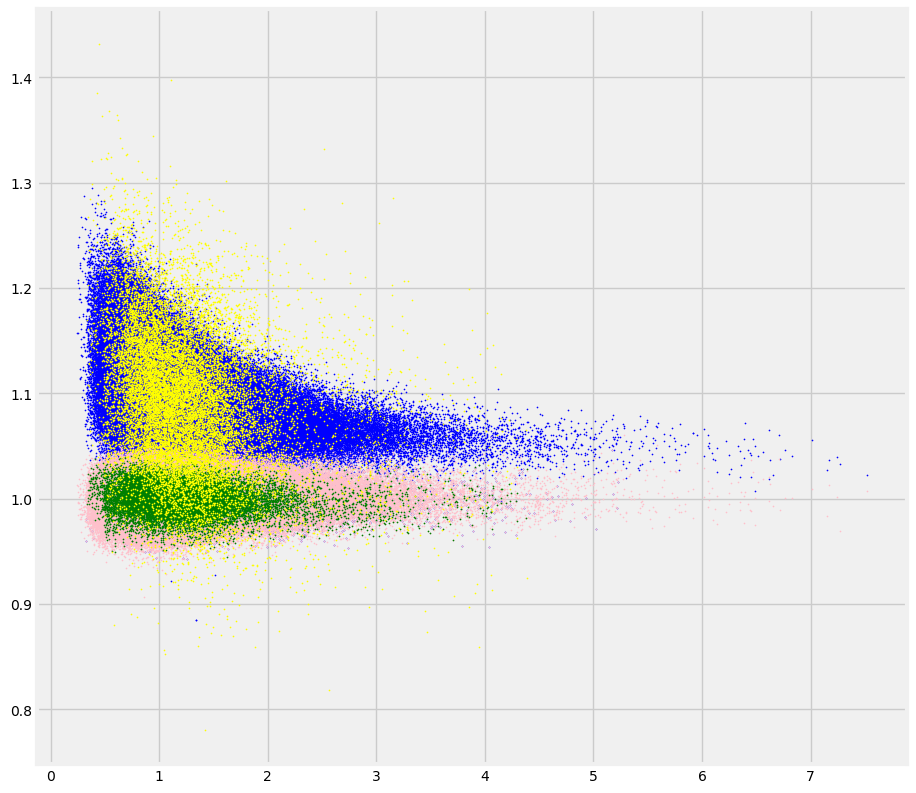

In [11]:
plt.figure(figsize=(10,10),dpi=100)
recs = recs.loc[recs.Hsig>0]
recs = recs.loc[recs.Hm0<10]

plt.scatter(recs_prim.Hsig,recs_prim.Hm0/recs_prim.Hsig,s=0.5,c='blue')
plt.scatter(recs_prim.Hsig,recs_prim.Hrms*np.sqrt(2)/recs_prim.Hsig,s=0.5,c='pink')
plt.scatter(recs.Hsig,recs.Hm*np.sqrt(2)/recs.Hsig,s=0.5,c='green')
plt.scatter(recs.Hsig,recs.Hm0/recs.Hsig,s=0.5,c='yellow')

plt.xrange=[0,max(recs.Hsig)]
plt.yrange=[0.7,1.4]
#plt.title(site)
plt.show()

C:\Users\Jim\AppData\Roaming\Python\Python37\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


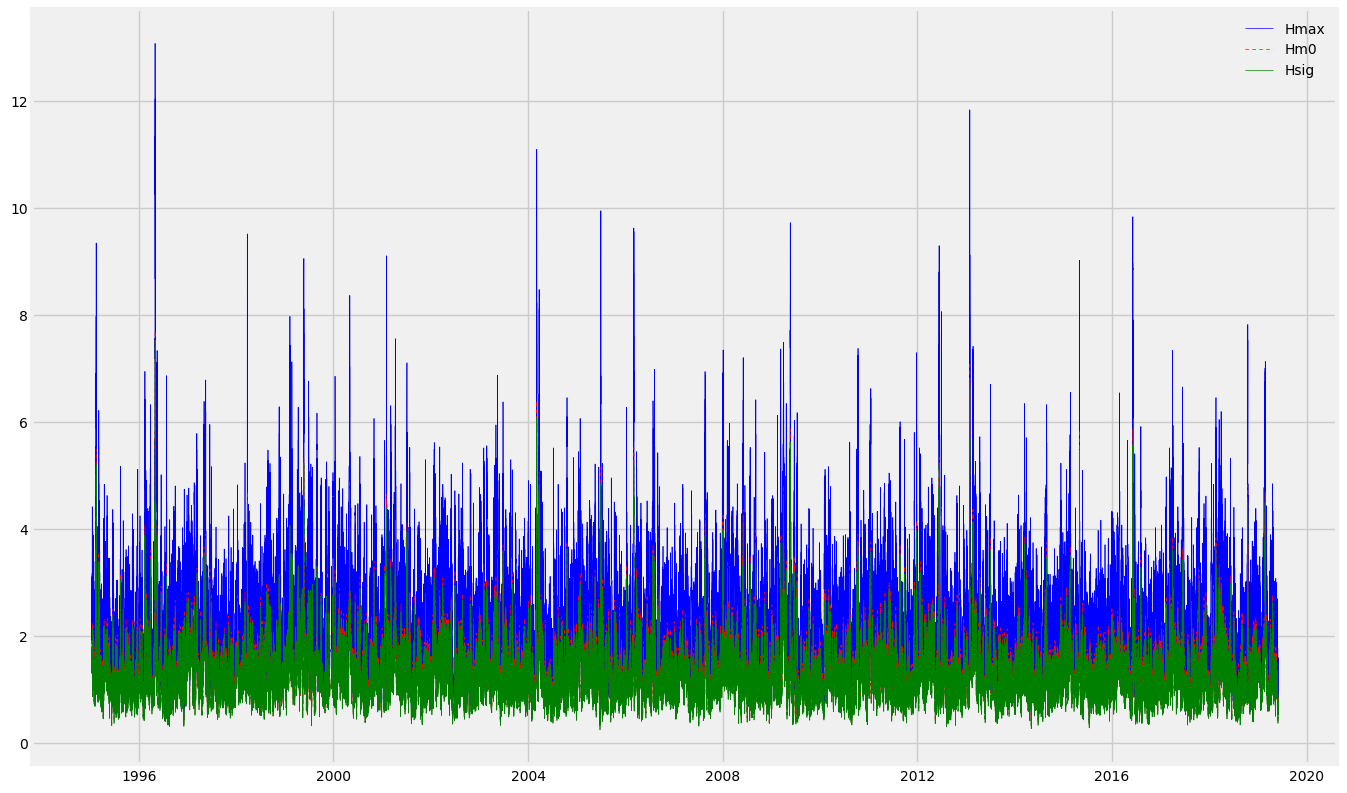

In [12]:
plt.figure(figsize=(15,10),dpi=100)
#plt.title(site)

# only plot records where Hsig > 0
recs_prim = recs_prim.loc[recs_prim.Hsig>0]

plt.plot(recs_prim.index,recs_prim.Hmax,lw=0.5,c="b")
plt.plot(recs_prim.index,recs_prim.Hm0,lw=0.5,c="r",dashes=[5, 5, 5, 5])
plt.plot(recs_prim.index,recs_prim.Hsig,lw=0.5,c="g")
plt.legend(["Hmax", "Hm0", "Hsig"],frameon=False)

plt.show()

In [ ]:
# Do scatter plot of T02/Tz Ratio

# Generate descriptive statistics of Hm0/Hsig Ratio’s distribution
Ratio = recs_prim.T02/recs_prim.Tz
median = Ratio.describe()[5]
plt.figure(figsize=(10,10),dpi=100)
recs_prim = recs_prim.loc[recs_prim.Hsig>0]
plt.scatter(recs_prim.Tz,recs_prim.T02/recs_prim.Tz,lw=0,marker='o',s=2)
plt.plot([0,max(recs_prim.Tz)],[median,median],lw=1.0,c="b",dashes=[5, 5, 5, 5])
plt.xlabel("Tz (s)")
plt.ylabel("T02/Tz")
plt.plot([0,max(recs_prim.Tz)],[1.0,1.0],lw=1.0,c="r",dashes=[5, 5, 5, 5])
plt.plot([0,max(recs_prim.Tz)],[0.5,0.5],lw=1.0,c="r",dashes=[5, 5, 5, 5])

plt.xlim(left=0,right=max(recs_prim.Tz))
plt.ylim(bottom=0.4,top=1.2)

plt.scatter(recs.Tz,recs.T02/recs.Tz,lw=0,marker='o',s=2,c='yellow')

#plt.title(site)
plt.show()

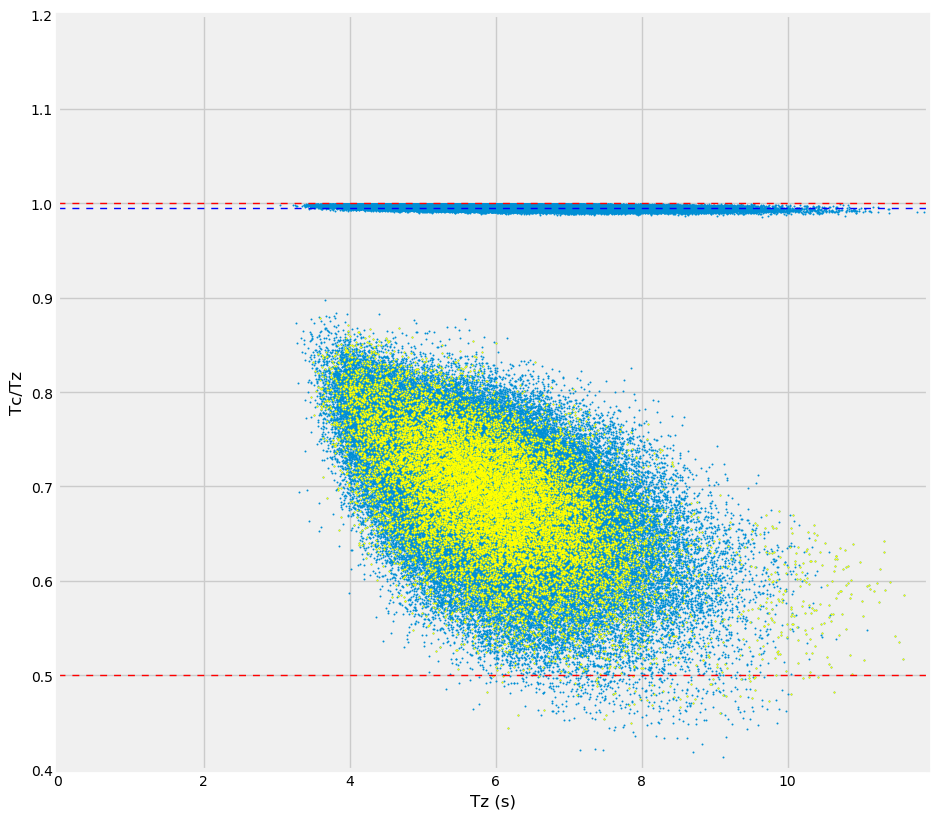

In [13]:
# Do scatter plot of Tc/Tz Ratio

# Generate descriptive statistics of Hm0/Hsig Ratio’s distribution
idx = recs.index.intersection(recs_prim.index)

Ratio = recs_prim.Tc/recs_prim.Tz
median = Ratio.describe()[5]
plt.figure(figsize=(10,10),dpi=100)
recs_prim = recs_prim.loc[recs_prim.Hsig>0]
plt.scatter(recs_prim.Tz,recs_prim.Tc/recs_prim.Tz,lw=0,marker='o',s=2)
plt.plot([0,max(recs_prim.Tz)],[median,median],lw=1.0,c="b",dashes=[5, 5, 5, 5])
plt.xlabel("Tz (s)")
plt.ylabel("Tc/Tz")
plt.plot([0,max(recs_prim.Tz)],[1.0,1.0],lw=1.0,c="r",dashes=[5, 5, 5, 5])
plt.plot([0,max(recs_prim.Tz)],[0.5,0.5],lw=1.0,c="r",dashes=[5, 5, 5, 5])

plt.xlim(left=0,right=max(recs_prim.Tz))
plt.ylim(bottom=0.4,top=1.2)

plt.scatter(recs.Tz,recs.Tc/recs.Tz,lw=0,marker='o',s=2,c='yellow')

#plt.title(site)
plt.show()

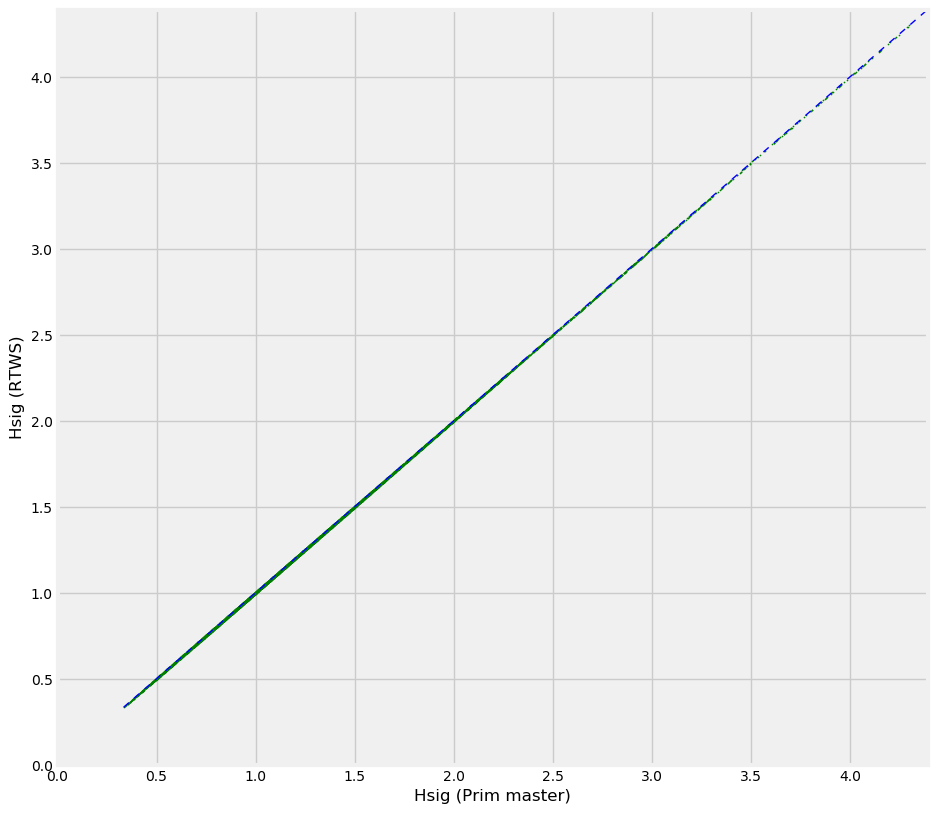

In [14]:
# Do scatter plot of Master file Hsig v's RTWS Hsig
plt.figure(figsize=(10,10),dpi=100)

idx = recs.index.intersection(recs_prim.index)
plt.scatter(recs_prim.loc[idx].Hsig,recs.loc[idx].Hsig,s=0.5,c='g')
plt.xlim(0,max(recs_prim.loc[idx].Hsig))
plt.ylim(0,max(recs.loc[idx].Hsig))
plt.xlabel("Hsig (Prim master)")
plt.ylabel("Hsig (RTWS)")
#plt.title(site)

from numpy.polynomial import Polynomial

p = Polynomial.fit(recs_prim.loc[idx].Hsig,recs.loc[idx].Hsig, 1)
plt.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])

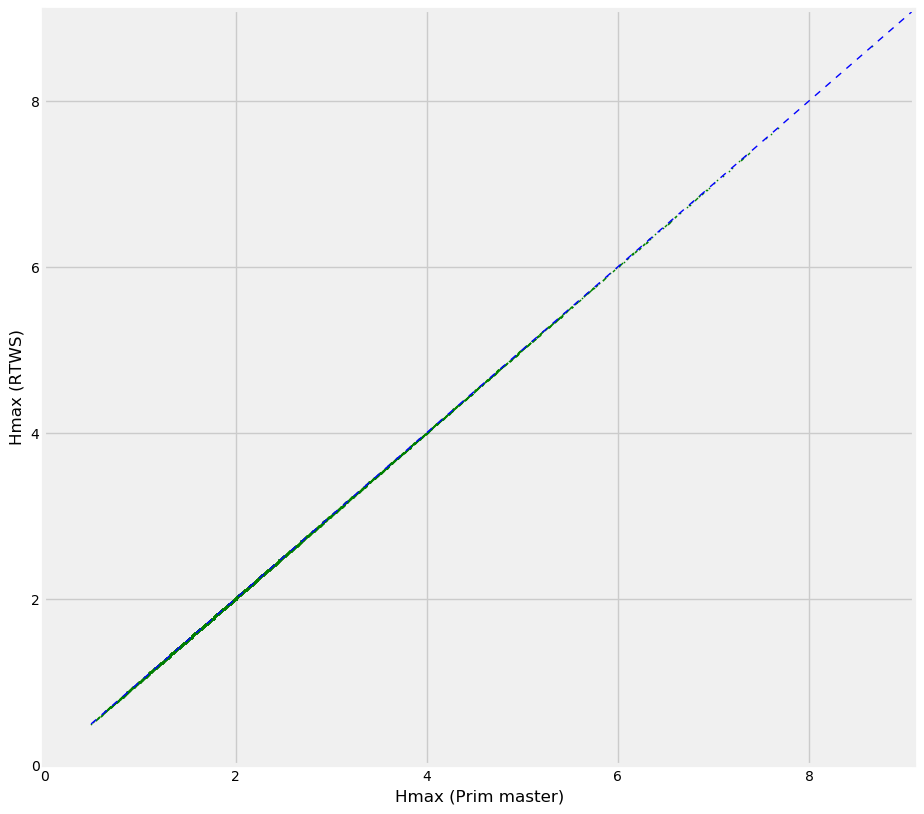

In [15]:
# Do scatter plot of Master file Hmax v's RTWS Hmax
plt.figure(figsize=(10,10),dpi=100)

idx = recs.index.intersection(recs_prim.index)
plt.scatter(recs_prim.loc[idx].Hmax,recs.loc[idx].Hmax,s=0.5,c='g')
plt.xlim(0,max(recs_prim.loc[idx].Hmax))
plt.ylim(0,max(recs.loc[idx].Hmax))
plt.xlabel("Hmax (Prim master)")
plt.ylabel("Hmax (RTWS)")
#plt.title(site)

from numpy.polynomial import Polynomial

p = Polynomial.fit(recs_prim.loc[idx].Hmax,recs.loc[idx].Hmax, 1)
plt.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])

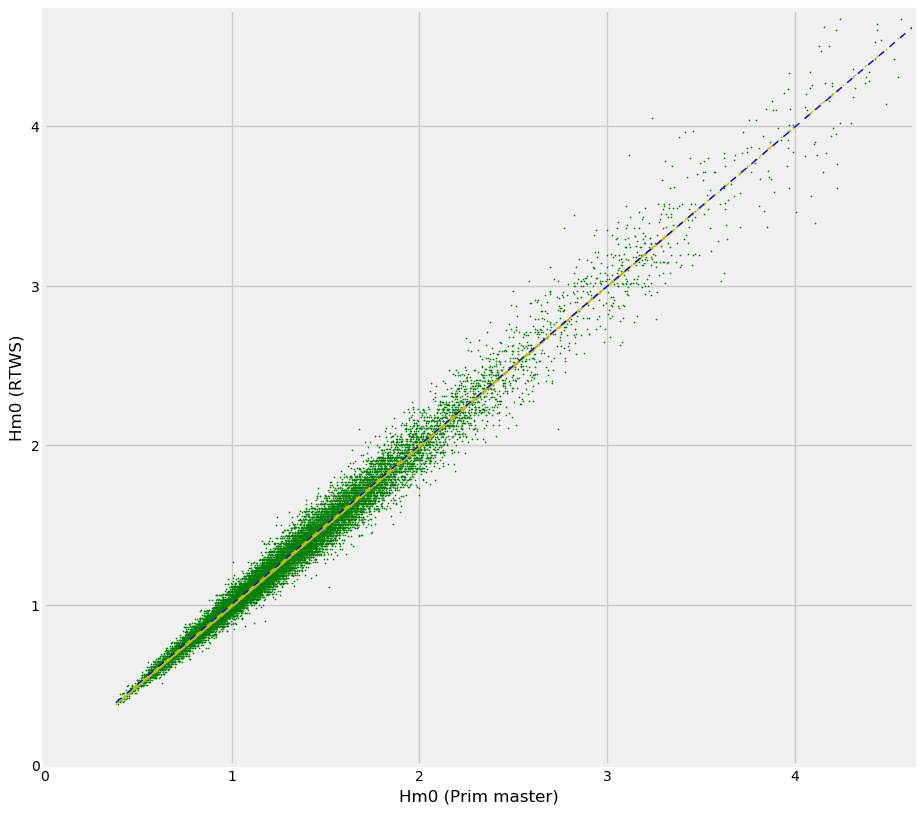

In [16]:
# Do scatter plot of Master file Hm0 v's RTWS Hm0
plt.figure(figsize=(10,10),dpi=100)

idx = recs.index.intersection(recs_prim.index)
plt.scatter(recs_prim.loc[idx].Hm0,recs.loc[idx].Hm0,s=0.5,c='g')
plt.scatter(recs_prim.loc[idx].Hm0,recs.loc[idx].Hrms*np.sqrt(2),s=0.5,c='y')
plt.xlim(0,max(recs_prim.loc[idx].Hm0))
plt.ylim(0,max(recs.loc[idx].Hm0))
plt.xlabel("Hm0 (Prim master)")
plt.ylabel("Hm0 (RTWS)")
#plt.title(site)

from numpy.polynomial import Polynomial

p = Polynomial.fit(recs_prim.loc[idx].Hm0,recs.loc[idx].Hm0, 1)
plt.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])

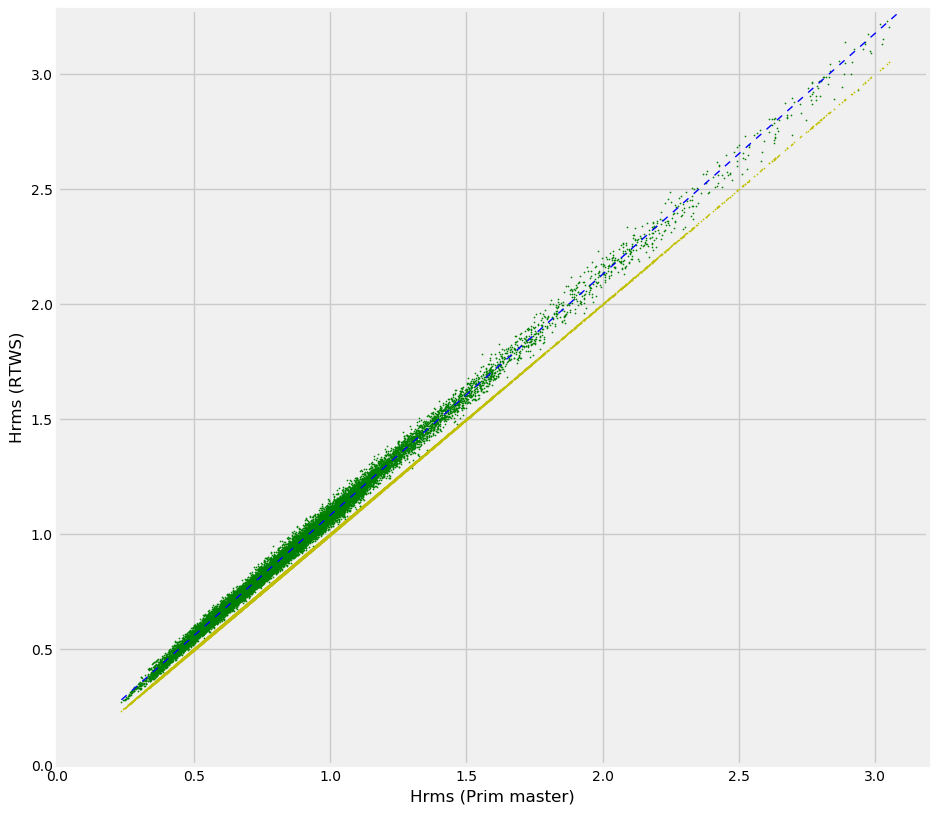

In [17]:
# Do scatter plot of Master file Hrms v's RTWS Hrms
plt.figure(figsize=(10,10),dpi=100)

idx = recs.index.intersection(recs_prim.index)
plt.scatter(recs_prim.loc[idx].Hrms,recs.loc[idx].Hrms,s=0.5,c='g')
plt.scatter(recs_prim.loc[idx].Hrms,recs.loc[idx].Hm,s=0.5,c='y')
plt.xlim(0,max(recs_prim.loc[idx].Hrms))
plt.ylim(0,max(recs.loc[idx].Hrms))
plt.xlabel("Hrms (Prim master)")
plt.ylabel("Hrms (RTWS)")
#plt.title(site)

from numpy.polynomial import Polynomial

p = Polynomial.fit(recs_prim.loc[idx].Hrms,recs.loc[idx].Hrms, 1)
plt.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])

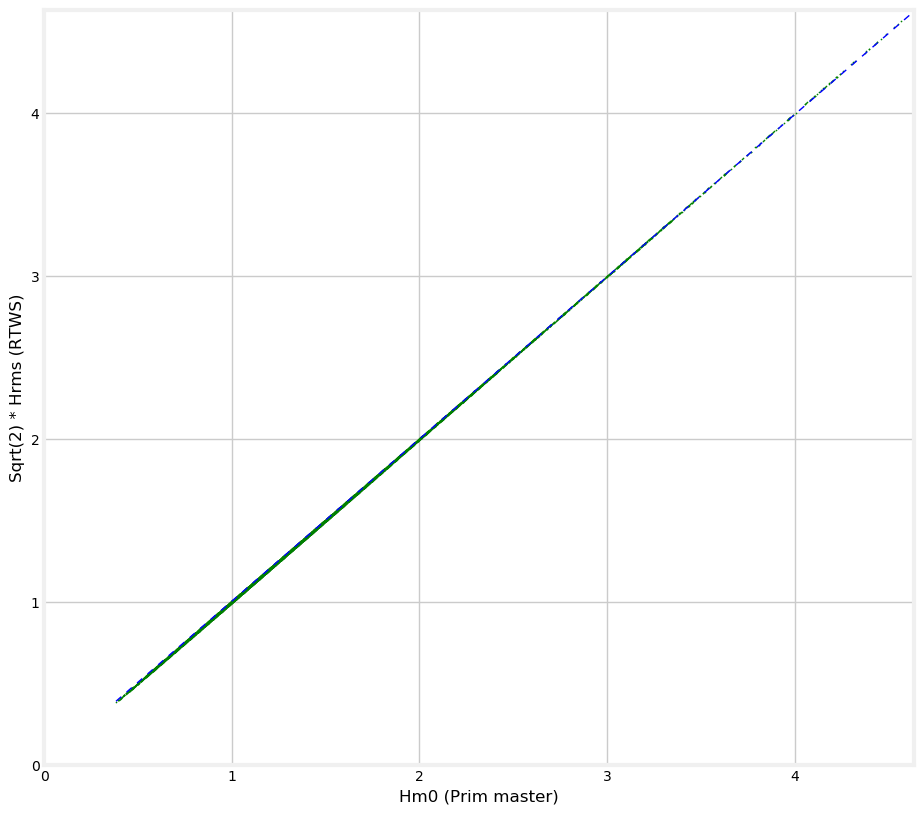

In [22]:
# Do scatter plot of  Master file Hm0 v's RTWS sqrt(2)* Hrms
plt.figure(figsize=(10,10),dpi=100)

idx = recs.index.intersection(recs_prim.index)
plt.scatter(recs_prim.loc[idx].Hm0,recs.loc[idx].Hrms*np.sqrt(2),s=0.5,c='g')
plt.xlim(0,max(recs_prim.loc[idx].Hm0))
plt.ylim(0,max(recs.loc[idx].Hrms*np.sqrt(2)))
plt.xlabel("Hm0 (Prim master)")
plt.ylabel("Sqrt(2) * Hrms (RTWS)")
#plt.title(site)

from numpy.polynomial import Polynomial

p = Polynomial.fit(recs_prim.loc[idx].Hm0,recs.loc[idx].Hm0, 1)
plt.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])

In [ ]:
# Do scatter plot of Master file Tc v's RTWS Tc
plt.figure(figsize=(10,10),dpi=100)

idx = recs.index.intersection(recs_prim.index)
plt.scatter(recs_prim.loc[idx].Tc,recs.loc[idx].Tc,s=0.5,c='g')
plt.xlim(min(recs_prim.loc[idx].Tc),max(recs_prim.loc[idx].Tc))
plt.ylim(min(recs.loc[idx].Tc),max(recs.loc[idx].Tc))
plt.xlabel("Tc (Prim master)")
plt.ylabel("Tc (RTWS)")
#plt.title(site)

from numpy.polynomial import Polynomial

p = Polynomial.fit(recs_prim.loc[idx].Tc,recs.loc[idx].Tc, 1)
plt.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])

In [ ]:
pd.options.display.max_columns = 100
recs

In [ ]:
recs

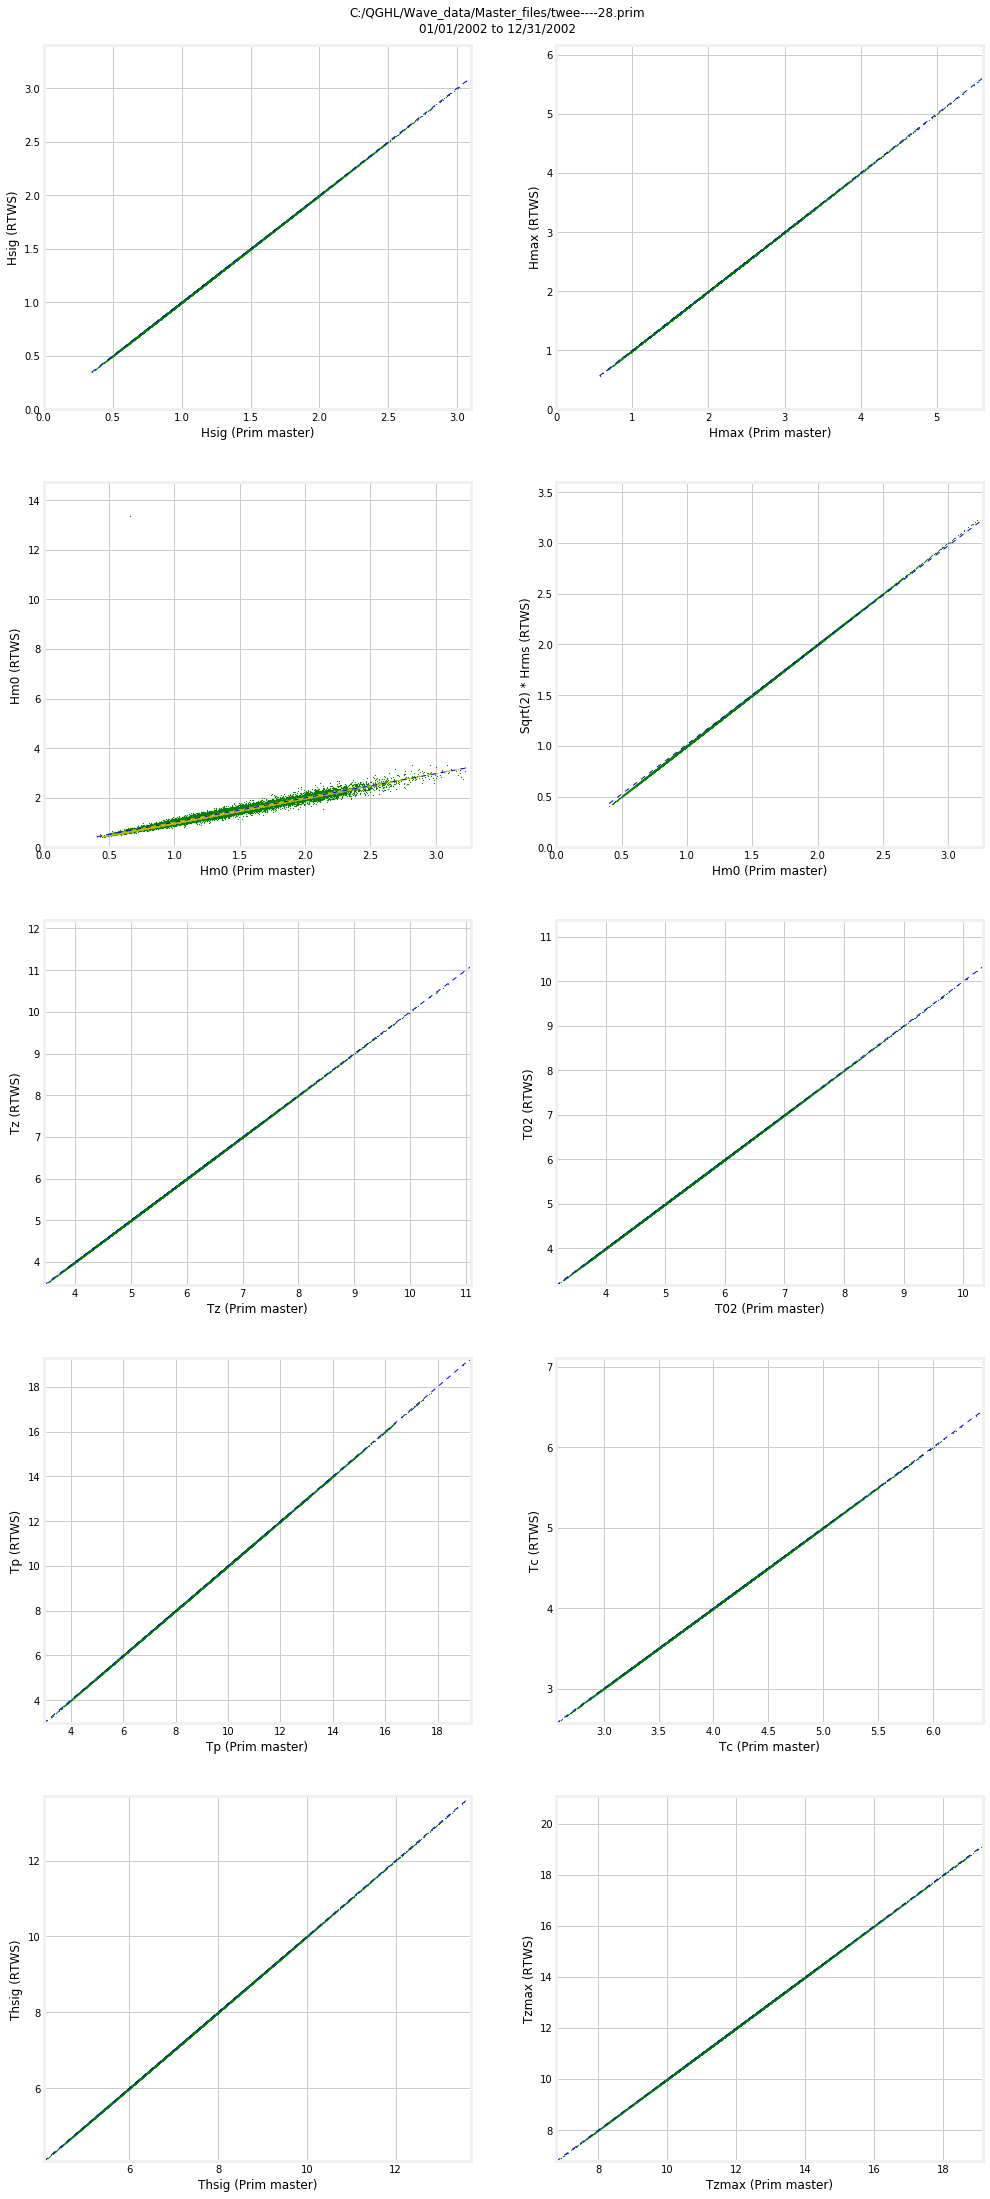

In [70]:
from matplotlib.dates import DateFormatter
from numpy.polynomial import Polynomial

# Display comparisons of main parameters between Prim master file and daily RTWS Prim files

details = recs_prim.describe()
plt.rcParams['axes.facecolor'] = 'white'
idx = recs.index.intersection(recs_prim.index)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(15,35), facecolor=(1, 1, 1))
fig.suptitle(Input_Prim_File+'\n'+(recs.loc[idx].index[0]).strftime('%m/%d/%Y')+' to '+(recs.loc[idx].index[-1]).strftime('%m/%d/%Y'))
#fig.tight_layout()
fig.subplots_adjust(top=0.965)

# Do scatter plot of Master file Hsig v's RTWS Hsig
idx = recs.index.intersection(recs_prim.index)
ax1.scatter(recs_prim.loc[idx].Hsig,recs.loc[idx].Hsig,s=0.5,c='g')
ax1.set_xlim(0,max(recs_prim.loc[idx].Hsig))
ax1.set_ylim(0,max(recs.loc[idx].Hsig)*1.1)
ax1.set_xlabel("Hsig (Prim master)")
ax1.set_ylabel("Hsig (RTWS)")

p = Polynomial.fit(recs_prim.loc[idx].Hsig,recs.loc[idx].Hsig, 1)
ax1.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])

# Do scatter plot of Master file Hmax v's RTWS Hmax
##idx = recs.index.intersection(recs_prim.index)
ax2.scatter(recs_prim.loc[idx].Hmax,recs.loc[idx].Hmax,s=0.5,c='g')
ax2.set_xlim(0,max(recs_prim.loc[idx].Hmax))
ax2.set_ylim(0,max(recs.loc[idx].Hmax)*1.1)
ax2.set_xlabel("Hmax (Prim master)")
ax2.set_ylabel("Hmax (RTWS)")

p = Polynomial.fit(recs_prim.loc[idx].Hmax,recs.loc[idx].Hmax, 1)
ax2.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])

# Do scatter plot of Master file Hm0 v's RTWS Hm0
ax3.scatter(recs_prim.loc[idx].Hm0,recs.loc[idx].Hm0,s=0.5,c='g')
ax3.scatter(recs_prim.loc[idx].Hm0,recs.loc[idx].Hrms*np.sqrt(2),s=0.5,c='y')
ax3.set_xlim(0,max(recs_prim.loc[idx].Hm0))
ax3.set_ylim(0,max(recs.loc[idx].Hm0)*1.1)
ax3.set_xlabel("Hm0 (Prim master)")
ax3.set_ylabel("Hm0 (RTWS)")

p = Polynomial.fit(recs_prim.loc[idx].Hm0,recs.loc[idx].Hm0, 1)
ax3.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])

# Do scatter plot of  Master file Hm0 v's RTWS sqrt(2)* Hrms
##idx = recs.index.intersection(recs_prim.index)
ax4.scatter(recs_prim.loc[idx].Hm0,recs.loc[idx].Hrms*np.sqrt(2),s=0.5,c='g')
ax4.set_xlim(0,max(recs_prim.loc[idx].Hm0))
ax4.set_ylim(0,max(recs.loc[idx].Hrms*np.sqrt(2))*1.1)
ax4.set_xlabel("Hm0 (Prim master)")
ax4.set_ylabel("Sqrt(2) * Hrms (RTWS)")

p = Polynomial.fit(recs_prim.loc[idx].Hm0,recs.loc[idx].Hm0, 1)
ax4.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])

# Do scatter plot of Master file Tz v's RTWS Tz
##idx = recs.index.intersection(recs_prim.index)
ax5.scatter(recs_prim.loc[idx].Tz,recs.loc[idx].Tz,s=0.5,c='g')
ax5.set_xlim(min(recs_prim.loc[idx].Tz),max(recs_prim.loc[idx].Tz))
ax5.set_ylim(min(recs.loc[idx].Tz),max(recs.loc[idx].Tz)*1.1)
ax5.set_xlabel("Tz (Prim master)")
ax5.set_ylabel("Tz (RTWS)")

p = Polynomial.fit(recs_prim.loc[idx].Tz,recs.loc[idx].Tz, 1)
ax5.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])

# Do scatter plot of Master file T02 v's RTWS T02
##idx = recs.index.intersection(recs_prim.index)
ax6.scatter(recs_prim.loc[idx].T02,recs.loc[idx].T02,s=0.5,c='g')
ax6.set_xlim(min(recs_prim.loc[idx].T02),max(recs_prim.loc[idx].T02))
ax6.set_ylim(min(recs.loc[idx].T02),max(recs.loc[idx].T02)*1.1)
ax6.set_xlabel("T02 (Prim master)")
ax6.set_ylabel("T02 (RTWS)")

p = Polynomial.fit(recs_prim.loc[idx].T02,recs.loc[idx].T02, 1)
ax6.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])

# Do scatter plot of Master file Tp v's RTWS Tp
##idx = recs.index.intersection(recs_prim.index)
ax7.scatter(recs_prim.loc[idx].Tp,recs.loc[idx].Tp,s=0.5,c='g')
ax7.set_xlim(min(recs_prim.loc[idx].Tp),max(recs_prim.loc[idx].Tp))
ax7.set_ylim(min(recs.loc[idx].Tp),max(recs.loc[idx].Tp))
ax7.set_xlabel("Tp (Prim master)")
ax7.set_ylabel("Tp (RTWS)")

p = Polynomial.fit(recs_prim.loc[idx].Tp,recs.loc[idx].Tp, 1)
ax7.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])

# Do scatter plot of Master file Tc v's RTWS Tc
ax8.scatter(recs_prim.loc[idx].Tc,recs.loc[idx].Tc,s=0.5,c='g')
ax8.set_xlim(min(recs_prim.loc[idx].Tc),max(recs_prim.loc[idx].Tc))
ax8.set_ylim(min(recs.loc[idx].Tc),max(recs.loc[idx].Tc)*1.1)
ax8.set_xlabel("Tc (Prim master)")
ax8.set_ylabel("Tc (RTWS)")

p = Polynomial.fit(recs_prim.loc[idx].Tc,recs.loc[idx].Tc, 1)
ax8.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])

# Do scatter plot of Master file Thsig v's RTWS Thsig
ax9.scatter(recs_prim.loc[idx].Thsig,recs.loc[idx].Thsig,s=0.5,c='g')
ax9.set_xlim(min(recs_prim.loc[idx].Thsig),max(recs_prim.loc[idx].Thsig))
ax9.set_ylim(min(recs.loc[idx].Thsig),max(recs.loc[idx].Thsig))
ax9.set_xlabel("Thsig (Prim master)")
ax9.set_ylabel("Thsig (RTWS)")

p = Polynomial.fit(recs_prim.loc[idx].Thsig,recs.loc[idx].Thsig, 1)
ax9.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])

# Do scatter plot of Master file Tzmax v's RTWS Tzmax
ax10.scatter(recs_prim.loc[idx].Tzmax,recs.loc[idx].Tzmax,s=0.5,c='g')
ax10.set_xlim(min(recs_prim.loc[idx].Tzmax),max(recs_prim.loc[idx].Tzmax))
ax10.set_ylim(min(recs.loc[idx].Tzmax),max(recs.loc[idx].Tzmax)*1.1)
ax10.set_xlabel("Tzmax (Prim master)")
ax10.set_ylabel("Tzmax (RTWS)")

p = Polynomial.fit(recs_prim.loc[idx].Tzmax,recs.loc[idx].Tzmax, 1)
ax10.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])


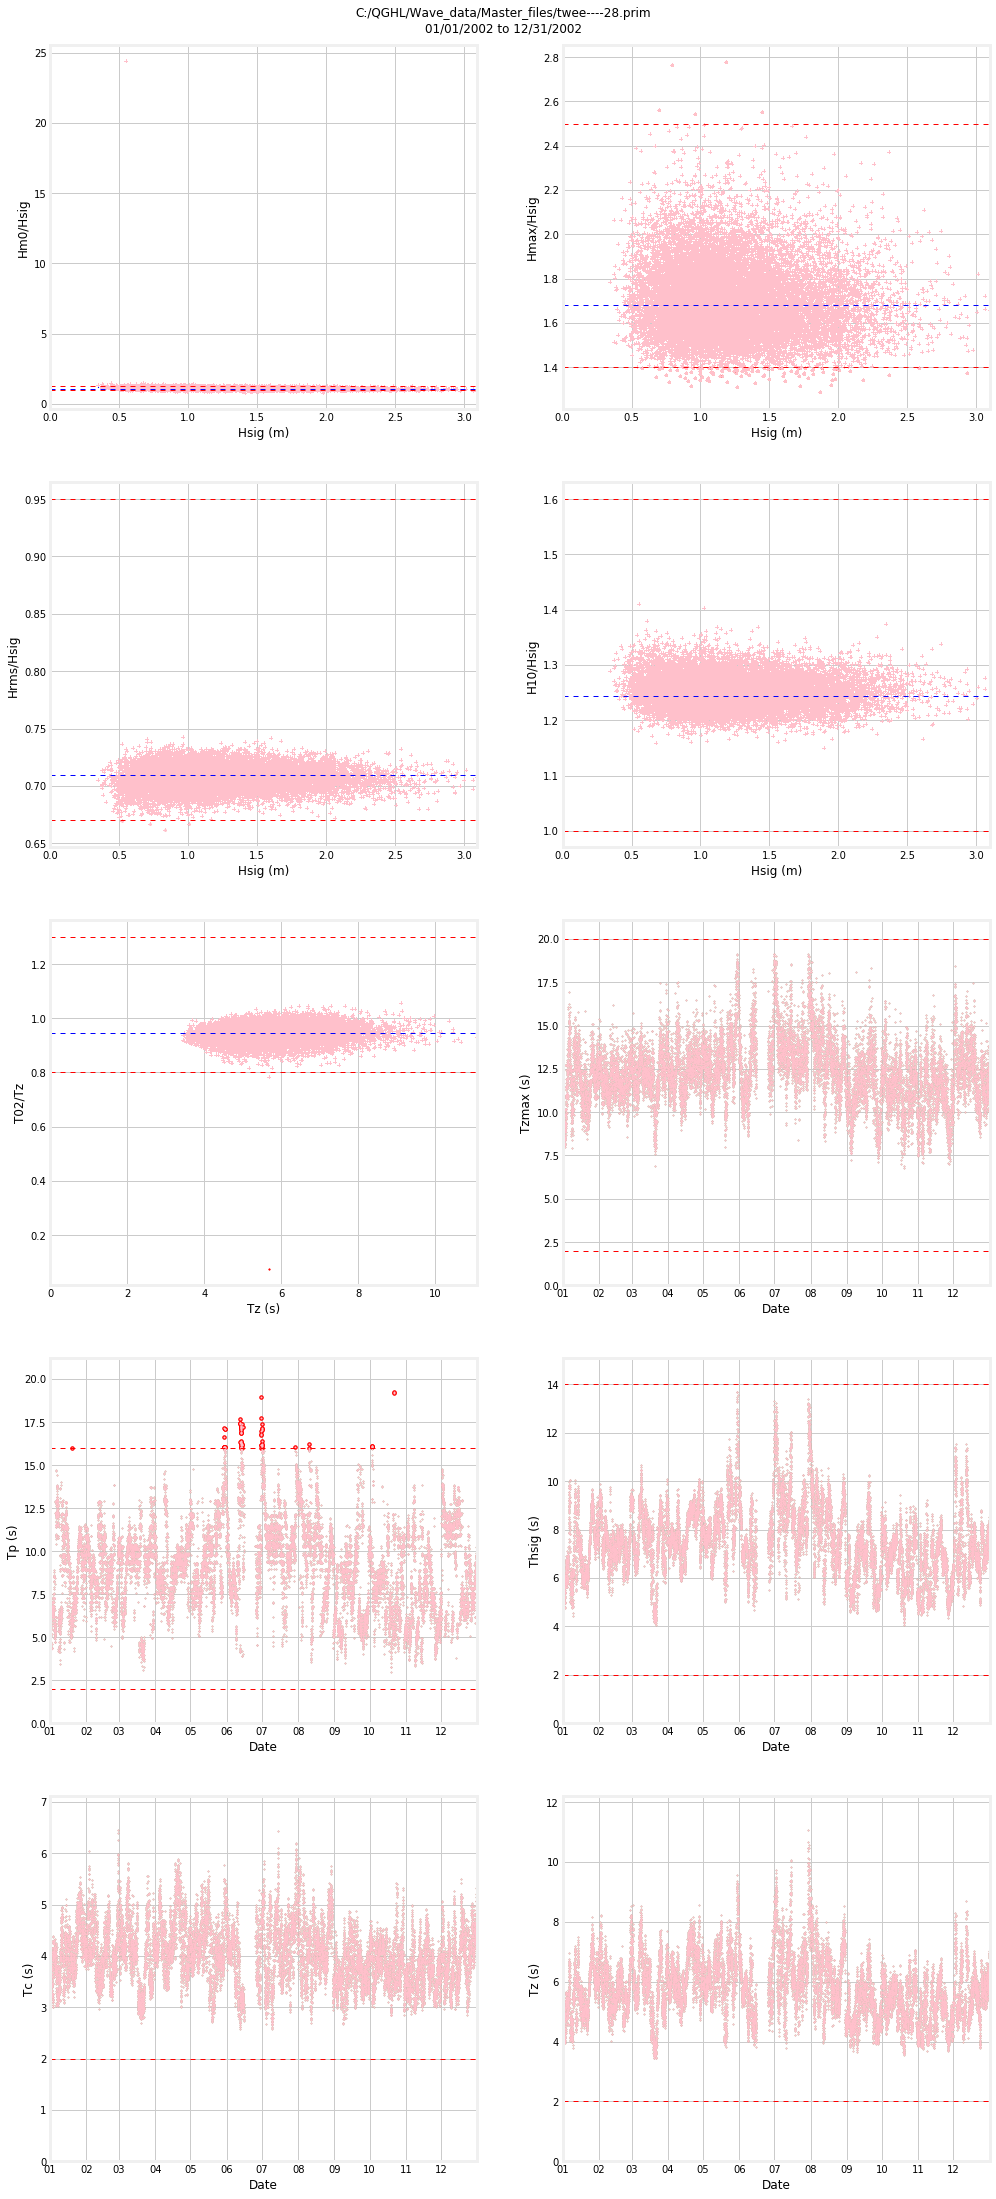

In [66]:
from matplotlib.dates import DateFormatter
from numpy.polynomial import Polynomial

# Display relationships in Prim master file

details = recs_prim.describe()
plt.rcParams['axes.facecolor'] = 'white'
idx = recs.index.intersection(recs_prim.index)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(15,35), facecolor=(1, 1, 1))
fig.suptitle(Input_Prim_File+'\n'+(recs.loc[idx].index[0]).strftime('%m/%d/%Y')+' to '+(recs.loc[idx].index[-1]).strftime('%m/%d/%Y'))
#fig.tight_layout()
fig.subplots_adjust(top=0.965)

# Do scatter plot of Master file Hm0/Hsig ratio v's RTWS Hm0/Hsig ratio
ax1.scatter(recs_prim.loc[idx].Hsig,recs_prim.loc[idx].Hm0/recs_prim.loc[idx].Hsig,s=0.5,c='b')
suspect_Hm0_Hsig = recs_prim.loc[idx][~(recs_prim.loc[idx].Hm0/recs_prim.loc[idx].Hsig).between(1.0,1.3,inclusive=False)]
ax1.scatter(suspect_Hm0_Hsig.Hsig,suspect_Hm0_Hsig.Hm0/suspect_Hm0_Hsig.Hsig,s=2.5,c='r')
ax1.scatter(recs.loc[idx].Hsig,recs.loc[idx].Hm0/recs.loc[idx].Hsig,marker='+',s=1.0,c='pink')
mode = details.Hm0[5]/details.Hsig[5]
ax1.plot([0,max(recs_prim.loc[idx].Hsig)],[mode,mode],lw=1.0,c="b",dashes=[5, 5, 5, 5])
ax1.set_xlim(0,max(recs_prim.loc[idx].Hsig))
ax1.set_xlabel("Hsig (m)")
ax1.set_ylabel("Hm0/Hsig")
ax1.plot([0,max(recs_prim.loc[idx].Hsig)],[1.3,1.3],lw=1.0,c="r",dashes=[5, 5, 5, 5])
ax1.plot([0,max(recs_prim.loc[idx].Hsig)],[1.0,1.0],lw=1.0,c="r",dashes=[5, 5, 5, 5])

# Do scatter plot of Master file Hmax/Hsig ratio v's RTWS Hmax/Hsig ratio
ax2.scatter(recs_prim.loc[idx].Hsig,recs_prim.loc[idx].Hmax/recs_prim.loc[idx].Hsig,s=0.5,c='b')
suspect_Hmax_Hsig = recs_prim.loc[idx][~(recs_prim.loc[idx].Hmax/recs_prim.loc[idx].Hsig).between(1.4,2.5,inclusive=False)]
ax2.scatter(suspect_Hmax_Hsig.Hsig,suspect_Hmax_Hsig.Hmax/suspect_Hmax_Hsig.Hsig,marker='o',s=3.5,c='r')
ax2.scatter(recs.loc[idx].Hsig,recs.loc[idx].Hmax/recs.loc[idx].Hsig,marker='+',s=1.0,c='pink')
mode = details.Hmax[5]/details.Hsig[5]
ax2.plot([0,max(recs_prim.loc[idx].Hsig)],[mode,mode],lw=1.0,c="b",dashes=[5, 5, 5, 5])
ax2.set_xlim(0,max(recs_prim.loc[idx].Hsig))
#ax2.set_ylim(min(recs_prim.loc[idx].Hmax/recs_prim.loc[idx].Hsig),max(recs_prim.loc[idx].Hmax/recs_prim.loc[idx].Hsig))
ax2.set_xlabel("Hsig (m)")
ax2.set_ylabel("Hmax/Hsig")
ax2.plot([0,max(recs_prim.loc[idx].Hsig)],[2.5,2.5],lw=1.0,c="r",dashes=[5, 5, 5, 5])
ax2.plot([0,max(recs_prim.loc[idx].Hsig)],[1.4,1.4],lw=1.0,c="r",dashes=[5, 5, 5, 5])

# Do scatter plot of Master file Hrms/Hsig ratio v's RTWS Hrms/Hsig ratio
ax3.scatter(recs_prim.loc[idx].Hsig,recs_prim.loc[idx].Hrms/recs_prim.loc[idx].Hsig,s=0.5,c='b')
suspect_Hrms_Hsig = recs_prim.loc[idx][~(recs_prim.loc[idx].Hrms/recs_prim.loc[idx].Hsig).between(0.67,0.75,inclusive=False)]
ax3.scatter(suspect_Hrms_Hsig.Hsig,suspect_Hrms_Hsig.Hrms/suspect_Hrms_Hsig.Hsig,marker='o',s=2.5,c='r')
ax3.scatter(recs.loc[idx].Hsig,recs.loc[idx].Hm/recs.loc[idx].Hsig,marker='+',s=1.0,c='pink')
mode = details.Hrms[5]/details.Hsig[5]
ax3.plot([0,max(recs_prim.loc[idx].Hsig)],[mode,mode],lw=1.0,c="b",dashes=[5, 5, 5, 5])
ax3.set_xlim(0,max(recs_prim.loc[idx].Hsig))
#ax3.set_ylim(min(recs_prim.loc[idx].Hrms/recs_prim.loc[idx].Hsig),max(recs_prim.loc[idx].Hrms/recs_prim.loc[idx].Hsig))
ax3.set_xlabel("Hsig (m)")
ax3.set_ylabel("Hrms/Hsig")
ax3.plot([0,max(recs_prim.loc[idx].Hsig)],[0.95,0.95],lw=1.0,c="r",dashes=[5, 5, 5, 5])
ax3.plot([0,max(recs_prim.loc[idx].Hsig)],[0.67,0.67],lw=1.0,c="r",dashes=[5, 5, 5, 5])

# Do scatter plot of Master file H10/Hsig ratio v's RTWS H10/Hsig ratio
ax4.scatter(recs_prim.loc[idx].Hsig,recs_prim.loc[idx].H10/recs_prim.loc[idx].Hsig,s=0.5,c='b')
suspect_H10_Hsig = recs_prim.loc[idx][~(recs_prim.loc[idx].H10/recs_prim.loc[idx].Hsig).between(1.0,1.6,inclusive=False)]
ax4.scatter(suspect_H10_Hsig.Hsig,suspect_H10_Hsig.Hrms/suspect_H10_Hsig.Hsig,marker='o',s=2.5,c='r')
ax4.scatter(recs.loc[idx].Hsig,recs.loc[idx].H10/recs.loc[idx].Hsig,marker='+',s=1.0,c='pink')
mode = details.H10[5]/details.Hsig[5]
ax4.plot([0,max(recs_prim.loc[idx].Hsig)],[mode,mode],lw=1.0,c="b",dashes=[5, 5, 5, 5])
ax4.set_xlim(0,max(recs_prim.loc[idx].Hsig))
#ax3.set_ylim(min(recs_prim.loc[idx].Hrms/recs_prim.loc[idx].Hsig),max(recs_prim.loc[idx].Hrms/recs_prim.loc[idx].Hsig))
ax4.set_xlabel("Hsig (m)")
ax4.set_ylabel("H10/Hsig")
ax4.plot([0,max(recs_prim.loc[idx].Hsig)],[1.6,1.6],lw=1.0,c="r",dashes=[5, 5, 5, 5])
ax4.plot([0,max(recs_prim.loc[idx].Hsig)],[1.0,1.0],lw=1.0,c="r",dashes=[5, 5, 5, 5])

# Do scatter plot of Master file T02/Tz ratio v's RTWS T02/Tz ratio
ax5.scatter(recs_prim.loc[idx].Tz,recs_prim.loc[idx].T02/recs_prim.loc[idx].Tz,s=0.5,c='b')
suspect_T02_Tz = recs_prim.loc[idx][~(recs_prim.loc[idx].T02/recs_prim.loc[idx].Tz).between(0.8,1.3,inclusive=False)]
ax5.scatter(suspect_T02_Tz.Tz,suspect_T02_Tz.Hrms/suspect_T02_Tz.Tz,marker='o',s=2.5,c='r')
ax5.scatter(recs.loc[idx].Tz,recs.loc[idx].T02/recs.loc[idx].Tz,marker='+',s=1.0,c='pink')
mode = details.T02[5]/details.Tz[5]
ax5.plot([0,max(recs_prim.loc[idx].Tz)],[mode,mode],lw=1.0,c="b",dashes=[5, 5, 5, 5])
ax5.set_xlim(0,max(recs_prim.loc[idx].Tz))
#ax3.set_ylim(min(recs_prim.loc[idx].Hrms/recs_prim.loc[idx].Hsig),max(recs_prim.loc[idx].Hrms/recs_prim.loc[idx].Hsig))
ax5.set_xlabel("Tz (s)")
ax5.set_ylabel("T02/Tz")
ax5.plot([0,max(recs_prim.loc[idx].Tz)],[1.3,1.3],lw=1.0,c="r",dashes=[5, 5, 5, 5])
ax5.plot([0,max(recs_prim.loc[idx].Tz)],[0.8,0.8],lw=1.0,c="r",dashes=[5, 5, 5, 5])

# Do plot of Master file Tzmax and RTWS Tzmax
ax6.plot(recs_prim.Tzmax,lw=0,marker='o',ms=0.5,c='g')
suspect_Tzmax = recs_prim.loc[idx][~(recs_prim.loc[idx].Tzmax).between(2.0,20.0,inclusive=False)]
ax6.plot(suspect_Tzmax.Tzmax,lw=0,marker='o',ms=3.5,c='r')
ax6.plot(recs.loc[idx].Tzmax,lw=0,marker='o',ms=1.0,c='pink')
ax6.set_xlabel("Date")
ax6.set_ylabel("Tzmax (s)")
ax6.set_xlim(recs_prim.loc[idx].index[0],recs_prim.loc[idx].index[-1])
ax6.set_ylim(0,max(recs_prim.loc[idx].Tzmax)*1.1)
ax6.plot([recs_prim.loc[idx].index[0],recs_prim.loc[idx].index[-1]],[20.0,20.0],lw=1.0,c="r",dashes=[5, 5, 5, 5])
ax6.plot([recs_prim.loc[idx].index[0],recs_prim.loc[idx].index[-1]],[2.0,2.0],lw=1.0,c="r",dashes=[5, 5, 5, 5])
myFmt = DateFormatter("%m")
ax6.xaxis.set_major_formatter(myFmt)

# Do plot of Master file Tp and RTWS Tp
ax7.plot(recs_prim.Tp,lw=0,marker='o',ms=0.5,c='g')
suspect_Tp = recs_prim.loc[idx][~(recs_prim.loc[idx].Tp).between(2.0,16.0,inclusive=False)]
ax7.plot(suspect_Tp.Tp,lw=0,marker='o',ms=3.5,c='r')
ax7.plot(recs.loc[idx].Tp,lw=0,marker='o',ms=1.0,c='pink')
ax7.set_xlabel("Date")
ax7.set_ylabel("Tp (s)")
ax7.set_xlim(recs_prim.loc[idx].index[0],recs_prim.loc[idx].index[-1])
ax7.set_ylim(0,max(recs_prim.loc[idx].Tp)*1.1)
ax7.plot([recs_prim.loc[idx].index[0],recs_prim.loc[idx].index[-1]],[16,16],lw=1.0,c="r",dashes=[5, 5, 5, 5])
ax7.plot([recs_prim.loc[idx].index[0],recs_prim.loc[idx].index[-1]],[2,2],lw=1.0,c="r",dashes=[5, 5, 5, 5])
myFmt = DateFormatter("%m")
ax7.xaxis.set_major_formatter(myFmt)

# Do plot of Master file Thsig and RTWS Thsig
ax8.plot(recs_prim.Thsig,lw=0,marker='o',ms=0.5,c='g')
suspect_Thsig = recs_prim.loc[idx][~(recs_prim.loc[idx].Thsig).between(2.0,14.0,inclusive=False)]
ax8.plot(suspect_Thsig.Thsig,lw=0,marker='o',ms=3.5,c='r')
ax8.plot(recs.loc[idx].Thsig,lw=0,marker='o',ms=1.0,c='pink')
ax8.set_xlabel("Date")
ax8.set_ylabel("Thsig (s)")
ax8.set_xlim(recs_prim.loc[idx].index[0],recs_prim.loc[idx].index[-1])
ax8.set_ylim(0,max(recs_prim.loc[idx].Thsig)+max(recs_prim.loc[idx].Thsig)/10)
ax8.plot([recs_prim.loc[idx].index[0],recs_prim.loc[idx].index[-1]],[14,14],lw=1.0,c="r",dashes=[5, 5, 5, 5])
ax8.plot([recs_prim.loc[idx].index[0],recs_prim.loc[idx].index[-1]],[2,2],lw=1.0,c="r",dashes=[5, 5, 5, 5])
myFmt = DateFormatter("%m")
ax8.xaxis.set_major_formatter(myFmt)

# Do plot of Master file Tc and RTWS Tc
ax9.plot(recs_prim.Tc,lw=0,marker='o',ms=0.5,c='g')
suspect_Tc = recs_prim.loc[idx][~(recs_prim.loc[idx].Tc).between(2.0,14.0,inclusive=False)]
ax9.plot(suspect_Tc.Tc,lw=0,marker='o',ms=3.5,c='r')
ax9.plot(recs.loc[idx].Tc,lw=0,marker='o',ms=1.0,c='pink')
ax9.set_xlabel("Date")
ax9.set_ylabel("Tc (s)")
ax9.set_xlim(recs_prim.loc[idx].index[0],recs_prim.loc[idx].index[-1])
ax9.set_ylim(0,max(recs_prim.loc[idx].Tc)*1.1)
ax9.plot([recs_prim.loc[idx].index[0],recs_prim.loc[idx].index[-1]],[14,14],lw=1.0,c="r",dashes=[5, 5, 5, 5])
ax9.plot([recs_prim.loc[idx].index[0],recs_prim.loc[idx].index[-1]],[2,2],lw=1.0,c="r",dashes=[5, 5, 5, 5])
myFmt = DateFormatter("%m")
ax9.xaxis.set_major_formatter(myFmt)

# Do plot of Master file Tz and RTWS Tz
ax10.plot(recs_prim.Tz,lw=0,marker='o',ms=0.5,c='g')
suspect_Tz = recs_prim.loc[idx][~(recs_prim.loc[idx].Tz).between(2.0,14.0,inclusive=False)]
ax10.plot(suspect_Tz.Tz,lw=0,marker='o',ms=3.5,c='r')
ax10.plot(recs.loc[idx].Tz,lw=0,marker='o',ms=1.0,c='pink')
ax10.set_xlabel("Date")
ax10.set_ylabel("Tz (s)")
ax10.set_xlim(recs_prim.loc[idx].index[0],recs_prim.loc[idx].index[-1])
ax10.set_ylim(0,max(recs_prim.loc[idx].Tz)*1.1)
ax10.plot([recs_prim.loc[idx].index[0],recs_prim.loc[idx].index[-1]],[14,14],lw=1.0,c="r",dashes=[5, 5, 5, 5])
ax10.plot([recs_prim.loc[idx].index[0],recs_prim.loc[idx].index[-1]],[2,2],lw=1.0,c="r",dashes=[5, 5, 5, 5])
myFmt = DateFormatter("%m")
ax10.xaxis.set_major_formatter(myFmt)

In [68]:
max(recs.loc[idx].Hm0)

13.369999885559082

In [71]:
max(recs_prim.loc[idx].Hm0)

3.2686641216278076